In [2]:
import json
from types import SimpleNamespace

import torch

import numpy as np
import ot
from matplotlib import pyplot as plt
%matplotlib inline

from utils.solvers import FISTA
from model.lista import VIEncoderLISTA, LISTA
from model.vi_encoder import VIEncoder
from model.scheduler import CycleScheduler
from utils.dict_plotting import show_dict, show_phi_vid

[]

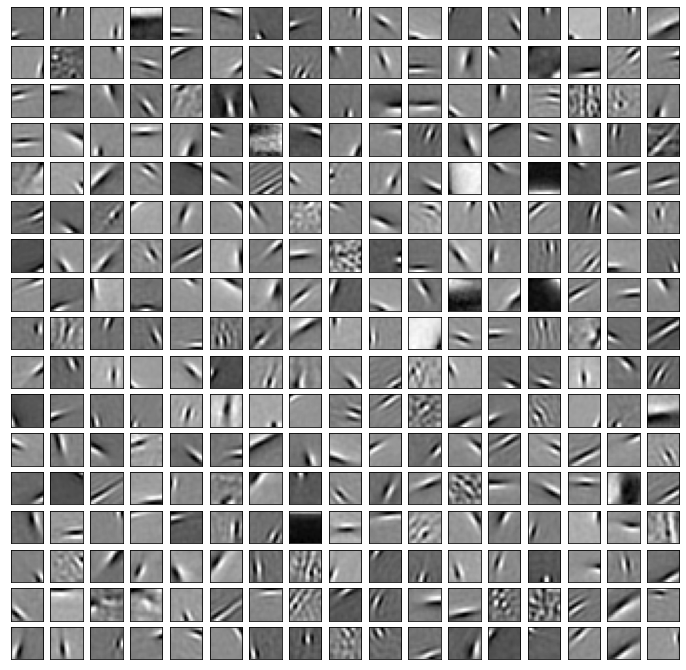

In [3]:
with open("results/VI_laplacian_coadapt/config.json") as json_data:
    config_data = json.load(json_data)
train_args = SimpleNamespace(**config_data['train'])
solver_args = SimpleNamespace(**config_data['solver'])

data_file = np.load("results/VI_laplacian_iwae/savefile_epoch199.npz")
phi = data_file['phi'][-1]

num_dictionaries = phi.shape[1]
patch_size = int(np.sqrt(phi.shape[0]))
fig = plt.figure(figsize=(12, 12))
for i in range(num_dictionaries):
    plt.subplot(int(np.sqrt(num_dictionaries)), int(np.sqrt(num_dictionaries)), i + 1)
    dict_element = phi[:, i].reshape(patch_size, patch_size)
    plt.imshow(dict_element, cmap='gray')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

In [10]:
code_count = 1000
real_images = False

if not real_images:
    true_support = 30
    random_codes = np.zeros((code_count, phi.shape[1]))
    support = np.random.randint(0, high=phi.shape[1], size=(code_count, true_support))
    for i in range(code_count):
        random_codes[i, support[i]] = np.random.randn(true_support)
    random_images = random_codes @ phi.T
else:
    data_file = f"data/imagepatches_16.np"
    if os.path.exists(data_file):
        with open(data_file, 'rb') as f:
            data_patches = np.load(f)
            val_patches = np.load(f)

    train_idx = np.linspace(1, data_patches.shape[0] - 1, code_count, dtype=int)
    random_images = data_patches[train_idx, :, :].reshape(-1, 16**2)
    random_images = random_images / np.linalg.norm(random_images, axis=1)[:, None]

    random_codes = np.zeros((code_count, phi.shape[1]))
    for i in range(code_count // 100):
        patches = random_images[i*100:(i+1)*100]
        random_codes[i*100:(i+1)*100] = FISTA(phi, patches.T, tau=solver_args.lambda_).T

In [6]:
epoch_load_list = ['FISTA', '0', '10', '50', '100', '200', '300']
save_dict = {}
recon_loss = {}
l1_loss = {}
true_coeffs = {}
est_coeffs = {}
epochs = 200

for epoch_file in epoch_load_list:
    np.random.seed(train_args.seed)
    torch.manual_seed(train_args.seed)
    train_patches = np.array(random_images)

    if epoch_file != 'FISTA':
        encoder = VIEncoder(train_args.patch_size, train_args.dict_size, solver_args).to('cuda')
        encoder.load_state_dict(torch.load(f"results/VI_laplacian_fixeddict/encoderstate_epoch{epoch_file}.pt")['model_state'])
        vi_opt = torch.optim.SGD(encoder.parameters(), lr=1e-3, #weight_decay=1e-4,
                            momentum=0.9, nesterov=True)
        vi_scheduler = CycleScheduler(vi_opt, 1e-3, 
                                        n_iter=(epochs * train_patches.shape[0]) // train_args.batch_size,
                                        momentum=None, warmup_proportion=0.05)

    #dictionary = np.array(phi)
    dictionary = np.random.randn(train_args.patch_size ** 2, train_args.dict_size)
    dictionary /= np.sqrt(np.sum(dictionary ** 2, axis=0))

    iter_per_epoch = train_patches.shape[0] // train_args.batch_size
    save_dict[epoch_file] = np.zeros((iter_per_epoch*epochs, *dictionary.shape))
    recon_loss[epoch_file] = np.zeros(iter_per_epoch*epochs)
    l1_loss[epoch_file] = np.zeros(iter_per_epoch*epochs)
    true_coeffs[epoch_file] = np.zeros((epochs, train_args.batch_size, dictionary.shape[1]))
    est_coeffs[epoch_file] = np.zeros((epochs, train_args.batch_size, dictionary.shape[1]))
    step_size = 1e-3

    for j in range(epochs):
        # Shuffle training data-set
        np.random.shuffle(train_patches)
        for i in range(train_patches.shape[0] // train_args.batch_size):
            save_dict[epoch_file][j*iter_per_epoch + i] = np.array(dictionary)
            patches = train_patches[i * train_args.batch_size:(i + 1) * train_args.batch_size].reshape(train_args.batch_size, -1).T

            if epoch_file != 'FISTA':
                patches_cu = torch.tensor(patches.T).float().to('cuda')
                dict_cu = torch.tensor(dictionary, device='cuda').float()
                iwae_loss, recon, kl_loss, b_cu = encoder(patches_cu, dict_cu)
                b = b_cu.detach().cpu().numpy().T
                
                #vi_opt.zero_grad()
                #iwae_loss.backward()
                #vi_opt.step()
                #vi_scheduler.step()
            else:
                b = FISTA(dictionary, patches, tau=solver_args.lambda_)

            generated_patch = dictionary @ b
            residual = patches - generated_patch
            step = residual @ b.T
            dictionary += step_size * step

            # Normalize dictionaries. Required to prevent unbounded growth, Tikhonov regularisation also possible.
            dictionary /= np.sqrt(np.sum(dictionary ** 2, axis=0))
            recon_loss[epoch_file][j*iter_per_epoch + i] = 0.5 * np.sum((patches - dictionary @ b) ** 2) 
            l1_loss[epoch_file][j*iter_per_epoch + i] = solver_args.lambda_ * np.sum(np.abs(b))

        b_true = FISTA(dictionary, patches, tau=solver_args.lambda_)
        true_coeffs[epoch_file][j] = b_true.T
        est_coeffs[epoch_file][j] = b.T

        step_size = step_size * 0.985
        print("Epoch {} of {}, Avg Train Loss = {:.4f}".format(j + 1, epochs, (recon_loss[epoch_file][j:(j+1)*iter_per_epoch] + l1_loss[epoch_file][j:(j+1)*iter_per_epoch]).mean()))

KeyboardInterrupt: 

In [1]:
epoch_names = [n if n == 'FISTA' else 'Epoch ' + n for n in epoch_load_list]
plt.figure(figsize=(8, 8))

for idx, run_name in enumerate(epoch_load_list):
    plt.semilogy(recon_loss[run_name] + l1_loss[run_name], label=epoch_names[idx]) 
plt.title("")
plt.xlabel("Iteration", fontsize=16)
plt.ylabel("Training Objective", fontsize=16)
plt.legend(fontsize=16)



NameError: name 'epoch_load_list' is not defined

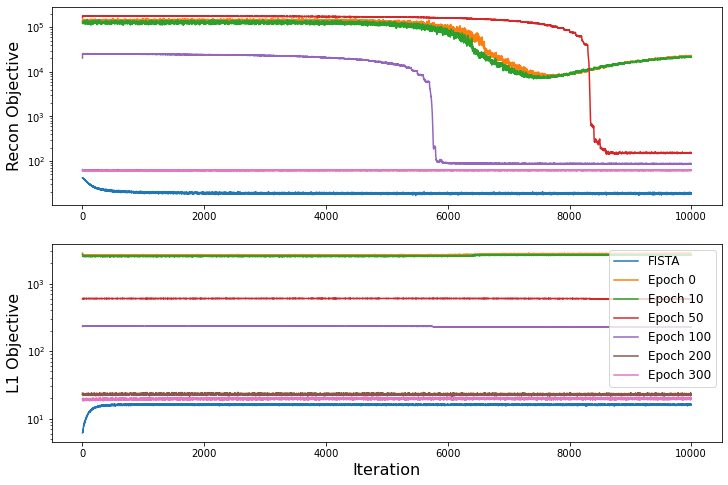

In [30]:
epoch_names = [n if n == 'FISTA' else 'Epoch ' + n for n in epoch_load_list]
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,8))

for idx, run_name in enumerate(epoch_load_list):
    ax[0].semilogy(recon_loss[run_name], label=epoch_names[idx]) 
    ax[1].semilogy(l1_loss[run_name], label=epoch_names[idx]) 

plt.title("")
plt.xlabel("Iteration", fontsize=16)
ax[0].set_ylabel("Recon Objective", fontsize=16)
ax[1].set_ylabel("L1 Objective", fontsize=16)

plt.legend(fontsize=12)



In [ ]:
for epoch_file in epoch_load_list:
    num_dictionaries = phi.shape[1]
    patch_size = int(np.sqrt(phi.shape[0]))
    fig = plt.figure(figsize=(12, 12))
    for i in range(num_dictionaries):
        plt.subplot(int(np.sqrt(num_dictionaries)), int(np.sqrt(num_dictionaries)), i + 1)
        dict_element = save_dict[epoch_file][10000, :, i].reshape(patch_size, patch_size)
        plt.imshow(dict_element, cmap='gray')
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

Error: Session cannot generate requests

In [ ]:
truecap_supp = {}
redundent_supp = {}
classification_acc = {}
active_supp = {}

for epoch_file in epoch_load_list:
    truecap_supp[epoch_file] = np.zeros(epochs)
    redundent_supp[epoch_file] = np.zeros(epochs)
    classification_acc[epoch_file] = np.zeros(epochs)
    active_supp[epoch_file] = np.zeros(epochs)

    for j in range(epochs):
        for i in range(train_args.batch_size):
            true_sup = np.nonzero(true_coeffs[epoch_file][j, i])[0]
            est_sup = np.nonzero(est_coeffs[epoch_file][j, i])[0]
            missed_support = np.setdiff1d(true_sup, est_sup)
            excess_support = np.setdiff1d(est_sup, true_sup)

            truecap_supp[epoch_file][j] += (1 - (len(missed_support) / dictionary.shape[1]))
            redundent_supp[epoch_file][j] += (len(excess_support) / dictionary.shape[1])
            classification_acc[epoch_file][j] += (dictionary.shape[1] - len(missed_support) - len(excess_support)) 
            active_supp[epoch_file][j] += len(est_sup)
        truecap_supp[epoch_file][j] /= (train_args.batch_size / 100.)
        redundent_supp[epoch_file][j] /= (train_args.batch_size / 100.)
        classification_acc[epoch_file][j] /= (train_args.batch_size * dictionary.shape[1] / 100.)
        active_supp[epoch_file][j] /= train_args.batch_size


Text(0.5, 1.0, 'Active Support')

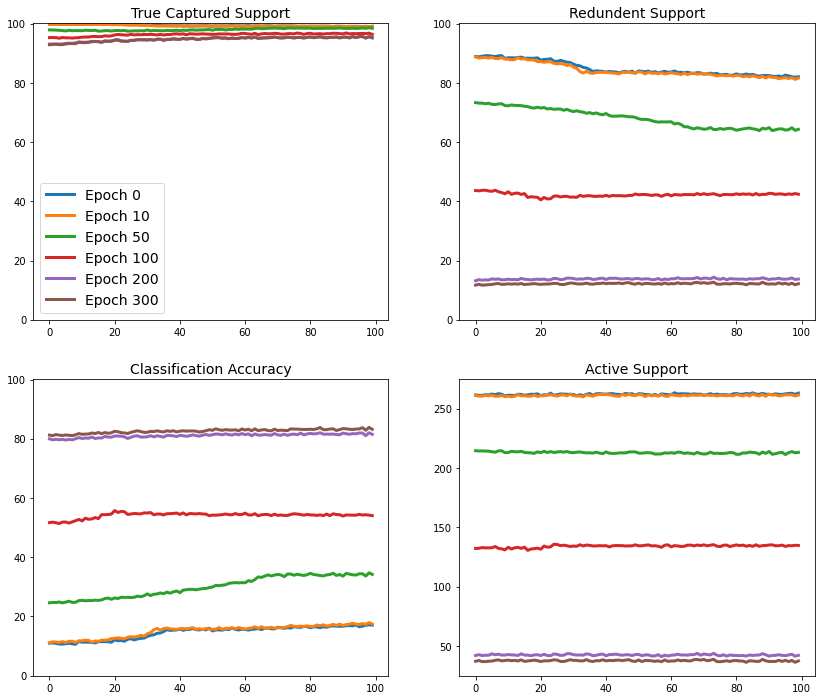

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,12))
for idx, epoch_file in enumerate(epoch_load_list):
    ax[0, 0].plot(truecap_supp[epoch_file], label=epoch_names[idx], linewidth=3)
    ax[0, 1].plot(redundent_supp[epoch_file], label=epoch_names[idx], linewidth=3)
    ax[1, 0].plot(classification_acc[epoch_file], label=epoch_names[idx], linewidth=3)
    ax[1, 1].plot(active_supp[epoch_file], label=epoch_names[idx], linewidth=3)

ax[0, 0].set_ylim([-.1, 100.1])
ax[0, 0].set_title("True Captured Support", fontsize=14)
ax[0, 0].legend(fontsize=14)

ax[0, 1].set_ylim([-.1, 100.1])
ax[0, 1].set_title("Redundent Support", fontsize=14)

ax[1, 0].set_ylim([-.1, 100.1])
ax[1, 0].set_title("Classification Accuracy", fontsize=14)

ax[1, 1].set_title("Active Support", fontsize=14)



In [14]:
noise_level = [0, 1e-2,  1e-1, 1e-2]
lambda_ = 0.1
gamma = 1e1

objective = 0.5 * np.sum((random_images - random_codes @ phi.T) ** 2) + lambda_ * np.abs(random_codes).sum()
gt_activations = random_codes[..., None] * phi.T
print(f"Ground truth obj value: {objective:.3E}")
print()

for noise in noise_level:
    noisy_images = random_images + np.random.randn(*random_images.shape)*noise
    epoch_names = [n if n == 'FISTA' else 'Epoch ' + n for n in epoch_load_list]
    for idx, method in enumerate(epoch_load_list):
        print(epoch_names[idx])
        if method == 'FISTA':
            code_est = FISTA(phi, noisy_images.T, tau=lambda_).T
        else:
            encoder = VIEncoder(train_args.patch_size, train_args.dict_size, solver_args).to('cuda:1')
            encoder.load_state_dict(torch.load(f"results/VI_laplacian_fixeddict/encoderstate_epoch{method}.pt")['model_state'])
            
            patches_cu = torch.tensor(noisy_images).float().to('cuda:1')
            dict_cu = torch.tensor(phi, device='cuda:1').float()
            iwae_loss, recon_loss, kl_loss, b_cu = encoder(patches_cu, dict_cu)
            code_est = b_cu.detach().cpu().numpy()
        objective = 0.5 * np.sum((random_images - code_est @ phi.T) ** 2) + lambda_ * np.abs(code_est).sum()
        coeff_dist = np.abs(code_est - random_codes).sum()
        activations = code_est[..., None] * phi.T

        num_true_supp = 0
        num_redundant_supp = 0
        classification_acc = 0
        avg_supp = 0
        emd = 0
        for i in range(code_count):
            true_sup = np.nonzero(random_codes[i])[0]
            est_sup = np.nonzero(code_est[i])[0]
            missed_support = np.setdiff1d(true_sup, est_sup)
            excess_support = np.setdiff1d(est_sup, true_sup)

            cost = ((activations[i, est_sup][:, None, :] - gt_activations[i, true_sup][None, ...])**2).sum(axis=-1)
            a = np.ones(len(est_sup)) / len(est_sup)
            b = np.ones(len(true_sup)) / len(true_sup)
            transport_plan = ot.sinkhorn(a, b, cost, gamma)
            emd += (transport_plan * cost).sum()

            num_true_supp += (1 - (len(missed_support) / random_codes.shape[1]))
            num_redundant_supp += (len(excess_support) / random_codes.shape[1])
            classification_acc += (code_est.shape[1] - len(missed_support) - len(excess_support)) 
            avg_supp += len(est_sup)

        num_true_supp /= (code_count / 100.)
        num_redundant_supp /= (code_count / 100.)
        classification_acc /= (code_count * code_est.shape[1] / 100.)
        avg_supp /= code_count
        emd /= code_count

        print(f"Noise {noise:.3f}, avg supp: {avg_supp}, true supp: {num_true_supp:.2f}%, redundent code: {num_redundant_supp:.2f}%")
        print(f"Obj value: {objective:.3E}, code L1 diff: {coeff_dist:.3E}, emd act: {emd:.3E}, clf acc: {classification_acc:.2f}%")
    print()

Ground truth obj value: 2.264E+03

FISTA
Noise 0.000, avg supp: 48.777, true supp: 98.01%, redundent code: 8.99%
Obj value: 2.027E+03, code L1 diff: 8.285E+03, emd act: 1.336E+00, clf acc: 89.02%
Epoch 0
Noise 0.000, avg supp: 262.178, true supp: 99.10%, redundent code: 81.74%
Obj value: 3.957E+05, code L1 diff: 2.883E+05, emd act: 3.285E+00, clf acc: 17.36%
Epoch 10
Noise 0.000, avg supp: 261.388, true supp: 99.04%, redundent code: 81.52%
Obj value: 3.693E+05, code L1 diff: 2.774E+05, emd act: 3.121E+00, clf acc: 17.52%
Epoch 50
Noise 0.000, avg supp: 216.648, true supp: 97.48%, redundent code: 67.61%
Obj value: 2.250E+04, code L1 diff: 8.772E+04, emd act: 1.169E+00, clf acc: 29.87%
Epoch 100
Noise 0.000, avg supp: 127.785, true supp: 94.56%, redundent code: 39.78%
Obj value: 1.755E+04, code L1 diff: 4.714E+04, emd act: 1.071E+00, clf acc: 54.78%
Epoch 200
Noise 0.000, avg supp: 16.201, true supp: 90.66%, redundent code: 5.07%
Obj value: 1.431E+04, code L1 diff: 2.332E+04, emd act: 9.

In [64]:
def compute_emd_act(base_act, perturb_act, gamma=1e-1):
    emd = 0
    for i in range(num_examples):
        cost = ((base_act[i, support[i, :total_supp]][:, None, :] - perturb_act[i, support[i, diff:]][None, ...])**2).sum(axis=-1)
        uni = np.ones(total_supp) / total_supp
        transport_plan = ot.emd(uni, uni, cost)#, gamma)
        emd += (transport_plan * cost).sum() / num_examples
    return emd

In [63]:
supp_diff = [0, 1, 5, 20]#, 1, 5, 20]
method = []
total_supp = 40
num_examples = 200
gamma = 5e-1

for diff in supp_diff:
    print(f"Support difference: {diff}")
    base_code = np.zeros((num_examples, phi.shape[1]))
    perturb_code = np.zeros((num_examples, phi.shape[1]))

    supp_count = total_supp + diff
    support = np.random.randint(0, high=phi.shape[1], size=(num_examples, supp_count))
    for i in range(num_examples):
        coeff_value = np.random.randn(total_supp + diff)
        base_code[i, support[i, :total_supp]] = coeff_value[:total_supp]
        perturb_code[i, support[i, diff:]] = coeff_value[diff:]

    base_image = base_code @ phi.T
    base_act = base_code[..., None] * phi.T
    perturb_image = perturb_code @ phi.T
    perturb_act = perturb_code[..., None] * phi.T
    gt_emd = compute_emd_act(base_act_est, perturb_act_est, gamma)
    gt_l1 = np.abs(base_code - perturb_code).sum()
    gt_obj = 0.5 * np.sum((base_image - base_code @ phi.T) ** 2) + 0.1 * np.abs(base_code).sum()
    print(f"Base emd: {gt_emd:.3E}, L1 diff: {gt_l1:.3E}, Obj: {gt_obj:.3E}")

    base_est = FISTA(phi, base_image.T, tau=0.1).T
    base_act_est = base_est[..., None] * phi.T
    perturb_est = FISTA(phi, perturb_image.T, tau=0.1).T
    perturb_act_est = perturb_est[..., None] * phi.T
    fista_emd = compute_emd_act(base_act_est, perturb_act_est, gamma)
    fista_l1 = np.abs(base_est - perturb_est).sum()
    fista_obj = 0.5 * np.sum((base_image - base_est @ phi.T) ** 2) + 0.1 * np.abs(base_est).sum()
    print(f"FISTA emd: {fista_emd:.2E}, L1 diff: {fista_l1:.3E},, Obj: {fista_obj:.3E}")

    for idx, method in enumerate(epoch_load_list):
        if method == 'FISTA':
            continue
        encoder = VIEncoder(train_args.patch_size, train_args.dict_size, solver_args).to('cuda:1')
        encoder.load_state_dict(torch.load(f"results/VI_laplacian_fixeddict/encoderstate_epoch{method}.pt")['model_state'])
        
        dict_cu = torch.tensor(phi, device='cuda:1').float()
        base_cu = torch.tensor(base_image).float().to('cuda:1')
        perturb_cu = torch.tensor(perturb_image).float().to('cuda:1')
        iwae_loss, recon_loss, kl_loss, base_b = encoder(base_cu, dict_cu)
        iwae_loss, recon_loss, kl_loss, perturb_b = encoder(perturb_cu, dict_cu)
        base_act_est = base_b[..., None].detach().cpu().numpy() * phi.T
        perturb_act_est = perturb_b[..., None].detach().cpu().numpy() * phi.T
        vsc_emd = compute_emd_act(base_act_est, perturb_act_est, gamma)
        vsc_l1 = torch.abs(base_b - perturb_b).sum()
        vsc_obj = 0.5 * np.sum((base_image - base_b.detach().cpu().numpy() @ phi.T) ** 2) + 0.1 * np.abs(base_b.detach().cpu().numpy()).sum()
        print(f"{epoch_names[idx]} emd: {vsc_emd:.2E}, L1 diff: {vsc_l1:.3E}, Obj: {vsc_obj:.3E}")
    print()


Support difference: 0
Base emd: 6.620E-05, L1 diff: 0.000E+00, Obj: 6.094E+02
FISTA emd: 3.14E-01, L1 diff: 0.000E+00,, Obj: 5.282E+02
Epoch 0 emd: 3.26E+00, L1 diff: 8.623E+04, Obj: 7.865E+04
Epoch 10 emd: 2.98E+00, L1 diff: 8.235E+04, Obj: 7.453E+04
Epoch 50 emd: 2.08E-01, L1 diff: 2.229E+03, Obj: 5.633E+03
Epoch 100 emd: 6.75E-02, L1 diff: 1.012E+03, Obj: 4.604E+03
Epoch 200 emd: 5.23E-04, L1 diff: 1.251E+02, Obj: 3.922E+03
Epoch 300 emd: 1.11E-04, L1 diff: 7.241E+01, Obj: 3.904E+03

Support difference: 1
Base emd: 1.048E-04, L1 diff: 3.227E+02, Obj: 5.997E+02
FISTA emd: 3.44E-01, L1 diff: 7.956E+02,, Obj: 5.226E+02
Epoch 0 emd: 3.24E+00, L1 diff: 8.584E+04, Obj: 8.066E+04
Epoch 10 emd: 3.03E+00, L1 diff: 8.298E+04, Obj: 7.485E+04
Epoch 50 emd: 2.08E-01, L1 diff: 2.277E+03, Obj: 5.524E+03
Epoch 100 emd: 6.43E-02, L1 diff: 1.031E+03, Obj: 4.499E+03
Epoch 200 emd: 4.11E-04, L1 diff: 1.211E+02, Obj: 3.816E+03
Epoch 300 emd: 9.28E-05, L1 diff: 7.266E+01, Obj: 3.801E+03

Support differen